---
# Plankton Recognition Challenge
## Group 18: Anh Tuan DAO - Thu Ha PHI 
---

As recommended, we work on 'level2' of  Hierachical Taxonomy Tree.

In this challenge, we focus on image dataset and using convolutional neural network.

# 1. Data preparation

## 1.1 Data explore

### Load image files and meta.csv
Firstly, we extracts the images stored inside the given zip file and read the "meta.csv" file. In the "meta.csv" file, we only use information of two columns that:
- The "level2" column contains labels of plankton that we concern in the classification problem. 
- The "objid" column contains the 'id' of image matching with the label in "level2" column

There are totally 243610 samples that is categorized into 39 classes.

### Find missing labeled samples
We remove all the samples having no label from the dataset. There are 1003 samples like that. After removing, the dataset remains 242607 samples.

### Draw distribution of image sizes
In the image classification, inputs images should have the same size. Thus, to find the most appropriate dimension of image to resize, we draw two distributions of images size in terms of width and height. These distributions can give us more insight of "the population" of imges size, and then possibly choose the most suitable dimension of images to resize. According to the figures, the most popular width/ height size of images is around 86 and 109. We decide to resize all images into 32x32 to avoid the limitation of RAM and reduce calculation cost. The number channel of images is 1, corresponding to grey scale images.

### Draw distribution of classes
- The important step is to discover the distribution of classes in the dataset. It can help us detect imbalance problem and how its level is. In Plankton dataset, we can clearly see that there is a serious imbalance among 39 classes. In particular, the majority class has 138439 samples while the minority class only has 12 samples.
- The serious imbalance dataset can result in the bias for the classifier because the loss will be dominated by the majority classes. The accuracy can still be high if the model is trained with an imbalanced dataset. However, it will not reflect much meaning due to the high accuracy mainly comes from the majority classes, not from minority classes.
- Thus, we suggest two methods to deal with imbalanced problems of dataset. The first one is to try resampling the dataset. The approach of this method is: we generate instances from the under-represented classes by modifying them by flipping both vertically and horizontally, Roting, Zooming, Scaling, Cropping. This process is called "Data Augumentaion". Simutaneously, we also delete instances from the over-represented classes to ensure the balance characteristics of the dataset. The ratio for generating and deleting depends on the intitial proportion of images in each class. The second method is 'class_weight' method. The class_weight is a dictionary of weights that defines each class and the weighting to apply in the calculation of loss function when fitting the model.


## 1.2 Data pre-processing



### Resize images and do Pixel Normalization
As we discuss above, we resize all the input images to 32x32 and scale pixel values to the range 0-1 to centering and even standardizing the values.

### Split data into train set, val set and test set
Then, we split the dataset into training set and testing set with the ratio 4:1. In training set, we continue to split it into 2 parts, one for training and one for validation, with the ratio 4:1. 

To ensure all the classes appear when training, testing and validating, we set a varible called "stratify".

## 1.3 Data Augmentation
As we explained, Data Augumentation is the process for up/down sampling instances from the original dataset to narrow the difference between over-represented classes and under-presented classes. For under-represented classes, we try flipping, roting, zooming, cropping from intial images to create more images. For over-represented classes, we randomly delete images. The ratio for generating or deleting images should depend on the intial proportion of images in each class.

We catogorized the classes into 5 levels of imbalance. It will help us easily to scale up/down the number of images in each class to ensure the balance characteristic. 
- For 'VeryLowFreqClasses' group that the number of sample less than 100, we generate the data by 200 times
- For 'LowFreqClasses' group that the number of sample n (n >= 100 and n < 1000), we scale up the number of image by 20 times
- For 'MediumFreqClasses' group that the number of sample n (n >= 1000 and n < 10000), we scale up the number of image by 2 times
- For 'HighFreqClasses' group, we keep unchange the number of images;
- In veryHighFreqClasses, we do the down-sampling to reduce the number of images downto 20000 per class.

After the augumentation process, we can see the new distribution of 39 classes in the figure below. The dataset now becomes more balanced.

1608


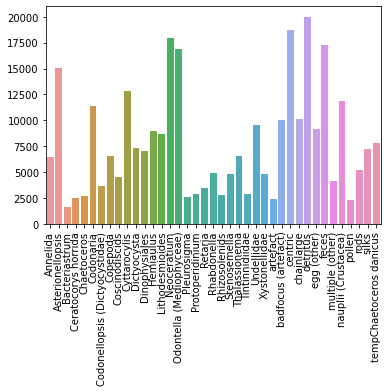

# 2. Model Selection

+ To clearly see the effect of the augumentation technique on the imbalanced classification problem; firstly we will train our model with the originally imbalanced dataset and use the right metrics to evaluate the performances of classifiers; after that, we will train our model with the augment dataset above and also use the same metrics to evaluate the performances of classifiers again. 
+ Actually, when working with an imbalanced dataset, the minority classes are typically  of the most interest. This means that the model's ability in correctly predicting the label of probability for the minority classes is more important than the majority classes. That is why we need to choose of metrics that give us more insight into the accuracy of the model rather than traditional classification accuracy. 


## 2.1 Metrics used: 
There are 4 types of metrics we use to evaluate the classifiers performances for the imbalanced dataset. 

Confusion metric: is a table that is often use to describe the performance of a classification model on a set of test data for which the true values are known.


| |              | Positive Prediction | Negative Prediction|
|---|------|------|------|
|<b>Actual<b>|Positive Class | True Positive (TP)  | False Negative (FN)|
| |Negative Class | False Positive (FP) | True Negative (TN)|

True positives (TP) and true negatives (TN) are the observations that are correctly predicted . 

We want to minimize false positives (FP) and false negatives (FN) which occur when our actual class contradicts with the predicted class. 

+ Precision: is the ratio of correctly predicted positive observations to the totally predicted positive observations. 

$$ Precision = \frac {TP} {TP+FP} $$

+ Recall (sensitivity): is the ratio of correctly predicted positive observations to the all observations in actually class "yes":

$$ Recall = \frac {TP} {TP+FN} $$

+ F1-score: is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is more useful than accuracy especially when we have the imbalanced-class distribution. 

$$ F_1 = \frac {2*(Recall*Precision)} {Recall+Precision} $$

+ Macro-Average F1-score: macro-average will compute the metric independently for each class and then take the average that treat all classes equally. 

In this challenge, we not only focus on the accuracy but also the Macro-Average F1-score. 



We focus on trying different CNN models because it is the best method for image classification. We start with a simple model, then try to train with more complicated models:

- Train with simple model (LeNet5) with (1) the original imbalance dataset, (2) the dataset after data augment, (3) the class weighted method
- Improve the LeNet5 model by adding 'dropout' layer and using 'relu' activation
- Apply transfer learning with complicated pre-trained model (VGG16) for our dataset
- Construct a new model which is suitable for the scope of our dataset.


**Firstly**, we want to try with a simple model and compare the performance of two methods (data augment method and class_weight method) when dealing with the imbalance problem.

We start with LeNet5 model for the first stage. It only has 7 layers, among which there are 3 convolutional layers, 2 sub-sampling pooling layers, and 1 fully connected layer, that are followed by the output layer. We choose categorical_crossentropy loss function as it is recommended for multi classes classification and the state-of-the-art 'adam' optimizer.

At this step, we only want to compare the performance of the two methods, so this simple model will save the time computation.

The results we got after training 50 epoches:

|      |Accuracy | Macro average F1 score | Weighted average F1 score |
|------|------|------|------|
| Original dataset |0.73|0.32|0.70|
|  Data augment    |0.60|0.31|0.62|
|  Class_weight method  |0.24|0.18|0.24|

At first glance, The origin dataset give the best results. However, when we calculate f1-score for each classes, we see that: 
- For the model trained on original dataset, there are a lot of classes which has zero f1-score (for example: Asterionellopsis, Bacteriastrum, Ceratocorys horrida which are classes having few sample training). In contrast, for models trained on data augment and class_weight method, there is only 1 class which has zero f1-score. It is also our expectation that the model not only focus on accuracy and weighted average f1-score, but also it has good Macro average f1-score and no class has zero f1-score.
- We see that, **the performance of data augment is outperform the one of class_weight method. Therefore, we will try different models on data augment dataset.**


**Secondly**, we continue training with three different models from simple to complicated:
- The simplest one, we improve the LeNet5 by adding 'dropout' layers and replace 'tanh' activation by 'relu' activation.
- The second one, we construct a medium complicated model. It has has 11 layers, among which there are 6 convolutional layers, 3 sub-sampling pooling layers, and 1 fully connected layer, that are followed by the output layer. All used activations are 'relu'. The 'BatchNormalization' layers and the 'dropout' layers are used after 'pooling' layers. 
- The most complicated one, we apply transfer learning technique for the complicated model (pre-trained VGG16 on 'imagenet' dataset)

All models are trained with 'categorical_crossentropy' loss function as it is recommended for multi classes classification and the 'adam' optimizer. The results we got after training 50 epoches:

|      |Accuracy | Macro average F1 score | Weighted average F1 score |
|------|------|------|------|
| customed LeNet5 |0.63|0.37|0.65|
|  Our model  |<b>0.73<b>|<b>0.55<b>|<b>0.74<b>|
|  VGG16    |0.62|0.36|0.66|


Due to the limitation on RAM on google colab, we only train VGG16 model on 50% of train dataset.
We can see that, our model is outperform the customed LeNet5 and VGG16. After that, we calculate f1-score for each classes. For our models, there is no class having zero f1-score. That is the result we expect. 

Finally, we tuning hyperparameters for our model to get the best model. Due to the time limitation, we only try different learning rate and the number of epoches. The best model we got with default learning rate(0.001) and the number of epoches = 100.

# Performance Evaluation
As mentioned above, **we not only focus on accuracy and weighted average f1-score, we also strongly want to improve macro average f1-score.**

The dataset is split into train set, validation set and test set to make sure that we performance evaluation on the unseen dataset. The 'stratify' is used in 'train_test_split' function to ensure the representative characteristic for validation set and test set. Data augumentation is only applied on training set.

After training our model with the best hyperparameters, we test the performance on test set and got the results:

|      |Accuracy | Macro average F1 score | Weighted average F1 score |
|------|------|------|------|
| Our best model on test set |0.74|0.58|0.75|

The calculate the precision, recall and f1-score on each classes on test set as shown in table below. We can see that, there is no class having zero f1-score.

              precision    recall  f1-score   support

           0       0.43      0.65      0.52        96
           1       0.47      0.78      0.59        23
           2       0.33      0.50      0.40         2
           3       0.51      0.59      0.55        37
           4       0.68      0.78      0.73       421
           5       0.73      0.73      0.73       169
           6       0.81      0.93      0.87       578
           7       0.81      0.69      0.74      1028
           8       0.52      0.72      0.60        67
           9       0.59      0.50      0.54        20
          10       0.78      0.85      0.81       110
          11       0.45      0.41      0.43       105
          12       0.52      0.78      0.62       134
          13       0.08      0.07      0.07        14
          14       0.87      0.95      0.91      2803
          15       0.34      0.81      0.48        26
          16       0.37      0.39      0.38        38
          17       0.73    

# Serendipity

- We implemented two methods (data augmentation and class_weight method) dealing with imbalance problem, then compared the performance before choosing the final method for this challenge.
- We showed the effect of the data augumentation on F1-score of each class, compared with F1-score when training with the original dataset.
- We chose appropriate metrics to evaluate the performance of the classifier.
- We used transfer learning technique for training a complicated model (VGG16).